# Thanks to [pycox](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/03_network_architectures.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
from torch import nn
import torch.nn.functional as F
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import LogisticHazard
from pycox.models.loss import NLLLogistiHazardLoss
from pycox.evaluation import EvalSurv

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [3]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [4]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


In [5]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [6]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

# Label transforms

The **LogisticHazard** is a discrete-time method, meaning it requires discretization of the event times to be applied to continuous-time data. We let **num_durations** define the size of this discretization grid, meaning our network will have **num_durations** output nodes.

Note that we have two sets of targets.

- The first, **y_train_surv**, is for the survival and contains the labels **(idx_durations, events)**.
- The second is for the autoencoder (which is just the input covariates **x_train**). This important to note, as it will define the call arguments of our loss function.

In [8]:
num_durations = 10
labtrans = LogisticHazard.label_transform(num_durations)
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train_surv = labtrans.fit_transform(*get_target(df_train))
y_val_surv = labtrans.transform(*get_target(df_val))

train = tt.tuplefy(x_train, (y_train_surv, x_train))
val = tt.tuplefy(x_val, (y_val_surv, x_val))

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [13]:
train[0].shape

(1218, 9)

In [8]:
y_train_surv

(array([2, 3, 6, ..., 1, 5, 3]),
 array([0., 1., 0., ..., 1., 0., 0.], dtype=float32))

# The Neural Net
We first define our network **NetAESurv** with contians the encoder, decoder, and the survival part.

We also include a **predict** method that saves computations by not computing the decoder.

In [14]:
class NetAESurv(nn.Module):
    def __init__(self, in_features, encoded_features, out_features):
        super().__init__()
        # Encode module
        self.encoder = nn.Sequential(
            nn.Linear(in_features, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, encoded_features),
        )
        # Decode module
        self.decoder = nn.Sequential(
            nn.Linear(encoded_features, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, in_features),
        )
        # Survival module
        self.surv_net = nn.Sequential(
            nn.Linear(encoded_features, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, out_features),
        )

    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        phi = self.surv_net(encoded)
        return phi, decoded

    def predict(self, input):
        # Will be used by model.predict later.
        # As this only has the survival output, 
        # we don't have to change LogisticHazard.
        encoded = self.encoder(input)
        return self.surv_net(encoded)

In [15]:
in_features = x_train.shape[1]
encoded_features = 4
out_features = labtrans.out_features
net = NetAESurv(in_features, encoded_features, out_features)

In [17]:
print(in_features, encoded_features, out_features, sep = '\n')

9
4
10


In [18]:
net

NetAESurv(
  (encoder): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=9, bias=True)
  )
  (surv_net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [11]:
train[1].levels

((1, 1), 0)

# The Loss

We need to define a loss that combines the **LogisticHazard** loss with the loss of an autoencoder **MLELoss**. The **forward** method defines how the loss is called, and need to be defined in accordance with how the data is structured.

The first arguments need to be the output of the net (**phi** and **decoded** above), and the reminder of the arguments need to have the same structure as the tumple structure of the targets in your data set, that is **train[1]**

In [20]:
train[1].levels

((1, 1), 0)

**train[1] = (target_loshaz, target_ae)** where **target_loghaz = (idx_durations, events)** and **target_ae** is just the input covariates. We need a loss with the call signature **loss(phi, decoded, target_loghaz, target_ae)**.

In [21]:
class LossAELogHaz(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        assert (alpha >= 0) and (alpha <= 1), 'Need `alpha` in [0, 1].'
        self.alpha = alpha
        self.loss_surv = NLLLogistiHazardLoss()
        self.loss_ae = nn.MSELoss()
        
    def forward(self, phi, decoded, target_loghaz, target_ae):
        idx_durations, events = target_loghaz
        loss_surv = self.loss_surv(phi, idx_durations, events)
        loss_ae = self.loss_ae(decoded, target_ae)
        return self.alpha * loss_surv + (1 - self.alpha) * loss_ae

In [22]:
loss = LossAELogHaz(0.6)

In [23]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss=loss)

/home/liucj/github/TEP-prognosis/venv/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Testing that it works

We can not test that everything works as expected by considering a single batch of data.

In [25]:
dl = model.make_dataloader(train, batch_size=5, shuffle=False)
batch = next(iter(dl))

In [26]:
batch.shapes()

(torch.Size([5, 9]), ((torch.Size([5]), torch.Size([5])), torch.Size([5, 9])))

In [27]:
batch.levels

(0, ((2, 2), 1))

In [18]:
??model.compute_metrics

Signature: model.compute_metrics(data, metrics=None) -> Dict[str, torch.Tensor]
Source:   
    def compute_metrics(self, data, metrics=None) -> Dict[str, torch.Tensor]:
        """Function for computing the loss and other metrics.
        
        Arguments:
            data {tensor or tuple} -- A batch of data. Typically the tuple `(input, target)`.

        Keyword Arguments:
            metrics {dict} -- A dictionary with metrics. If `None` use `self.metrics`. (default: {None})
        """
        if metrics is None:
            metrics = self.metrics
        if (self.loss is None) and (self.loss in metrics.values()):
            raise RuntimeError(f"Need to set `self.loss`.")

        input, target = data
        input = self._to_device(input)
        target = self._to_device(target)
        out = self.net(*input)
        out = tuplefy(out)
        return {name: metric(*out, *target) for name, metric in metrics.items()}
File:      ~/github/TEP-prognosis/venv/lib/python3.6/site-pack

In [28]:
model.compute_metrics(batch)

{'loss': tensor(2.1274, grad_fn=<AddBackward0>)}

In [29]:
model.score_in_batches(*train)

{'loss': 2.1353518962860107}

# Training

In [30]:
metrics = dict(
    loss_surv = LossAELogHaz(1),
    loss_ae   = LossAELogHaz(0)
)
callbacks = [tt.cb.EarlyStopping()]

In [31]:
batch_size = 256
epochs = 100


In [32]:
log = model.fit(*train, batch_size, epochs, callbacks, False, val_data=val, metrics=metrics)

In [33]:
res = model.log.to_pandas()

In [34]:
res.head()

,train_loss,train_loss_surv,train_loss_ae,val_loss,val_loss_surv,val_loss_ae
0,2.017830,2.867396,0.743481,1.819107,2.615145,0.625048
1,1.674196,2.350554,0.659657,1.358918,1.879998,0.577298
2,1.287573,1.739275,0.610021,1.153762,1.575736,0.520800
3,1.202348,1.636808,0.550657,1.036035,1.416232,0.465740
4,1.116045,1.528648,0.497141,1.055353,1.471618,0.430954


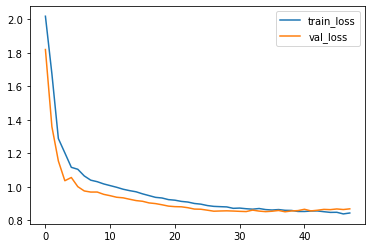

In [35]:
_ = res[['train_loss', 'val_loss']].plot()

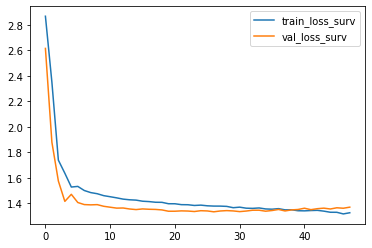

In [36]:
_ = res[['train_loss_surv', 'val_loss_surv']].plot()

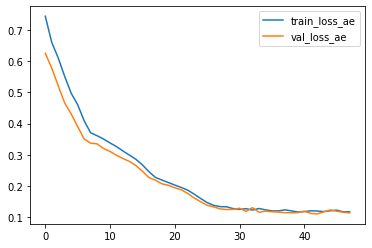

In [37]:
_ = res[['train_loss_ae', 'val_loss_ae']].plot()

# Prediction
For prediction, remember that **model.predict** use the **net.predict** method, and because we defined it as only the survival part, the **predict_surv_df** behave as before.

In [38]:
surv = model.interpolate(10).predict_surv_df(x_test)

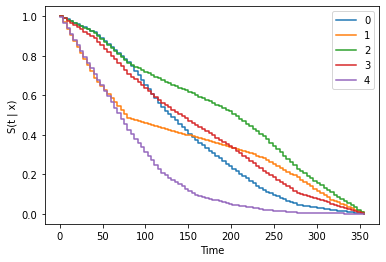

In [39]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [40]:
model.predict(x_test[:2])

array([[ -8.997378  ,  -2.4341526 ,  -1.6364884 ,  -0.85037184,
         -0.8092156 ,  -0.60200864,   0.02750829,   0.47825658,
          0.12457347,   6.492566  ],
       [-10.778178  ,  -0.7977779 ,  -0.85222805,  -2.18329   ,
         -2.11158   ,  -1.9861343 ,  -1.6025864 ,  -0.6204622 ,
          0.43677408,   7.058006  ]], dtype=float32)

In [41]:
model.predict_net(x_test[:2])

(array([[ -8.997378  ,  -2.4341526 ,  -1.6364884 ,  -0.85037184,
          -0.8092156 ,  -0.60200864,   0.02750829,   0.47825658,
           0.12457347,   6.492566  ],
        [-10.778178  ,  -0.7977779 ,  -0.85222805,  -2.18329   ,
          -2.11158   ,  -1.9861343 ,  -1.6025864 ,  -0.6204622 ,
           0.43677408,   7.058006  ]], dtype=float32),
 array([[-0.7573004 ,  2.2581406 , -0.35484448,  1.5869446 ,  0.51991916,
          0.8161951 ,  0.6196202 ,  0.10317728,  0.89904773],
        [-0.39073348, -0.70861685,  2.3197536 ,  1.102318  , -1.2164323 ,
          0.30310687,  0.63157314,  0.60098314,  0.40127072]],
       dtype=float32))

In [42]:
model.predict_net(x_test[:2], func=lambda x: x[0])

array([[ -8.997378  ,  -2.4341526 ,  -1.6364884 ,  -0.85037184,
         -0.8092156 ,  -0.60200864,   0.02750829,   0.47825658,
          0.12457347,   6.492566  ],
       [-10.778178  ,  -0.7977779 ,  -0.85222805,  -2.18329   ,
         -2.11158   ,  -1.9861343 ,  -1.6025864 ,  -0.6204622 ,
          0.43677408,   7.058006  ]], dtype=float32)

# Evaluation (as before)
The **EvalSurv** class contains some useful evaluation criteria for time-to-event prediction. We set **censor_surv='km'** to state that we want to use **Kaplan-Meier** for estimating the censoring distribution.

In [43]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

# Concordance
We start with the event-time concordance

In [44]:
ev.concordance_td('antolini')

/home/liucj/github/TEP-prognosis/venv/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 7000. The TBB threading layer is disabled.
  warnings.warn(problem)


0.6756539064818348

# Brief Score
We can plot the IPCW Brief score for a given set of times.

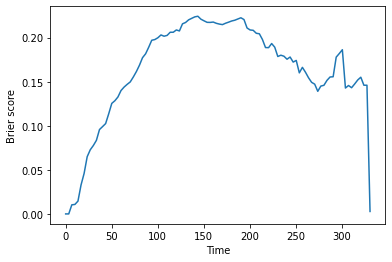

In [45]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

# Negative binomial log-likelihood

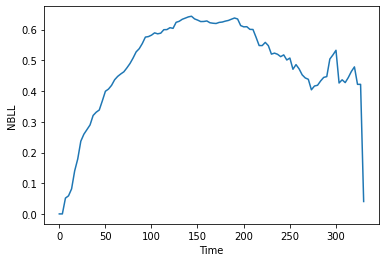

In [46]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

# Integrated scores

In [47]:
ev.integrated_brier_score(time_grid) 

0.16415469424501059

In [48]:
ev.integrated_nbll(time_grid) 

0.4855299165903208